In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam/spam.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv


This initial portion of the project was done with assistance from https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [4]:
# import libraries for reading data, exploring and plotting
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

Setting up the dataframe from the csv:

In [30]:
messages = pd.read_csv('/kaggle/input/sms-spam/spam.csv', encoding = "ISO-8859-1")
messages.drop(messages.columns[[2,3,4]], axis=1, inplace=True)
messages.rename(columns={"v1":"label","v2":"message"}, inplace=True)
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Seperate out ham and spam messages, where ham are normal messages and spam are, well... spam.

In [31]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In order to better visualize what the text sets consist of, WordClouds can be generated of both the ham and spam datasets.

# WordCloud of ham

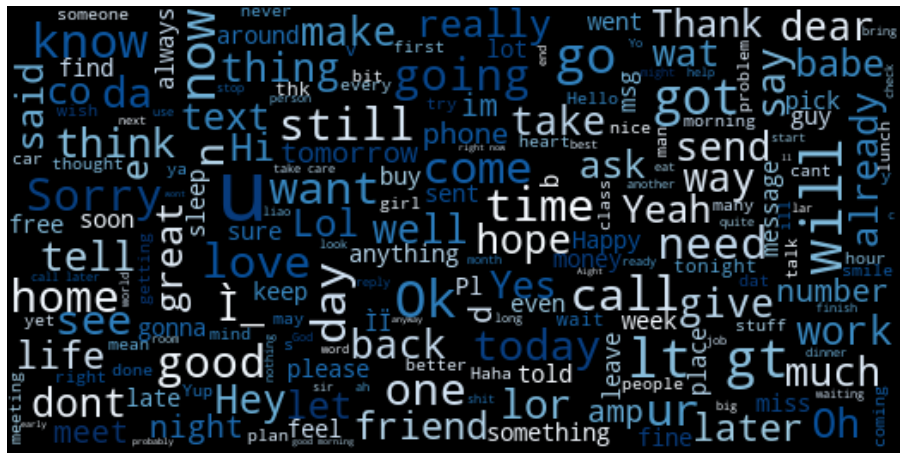

In [32]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

# WordCloud of spam

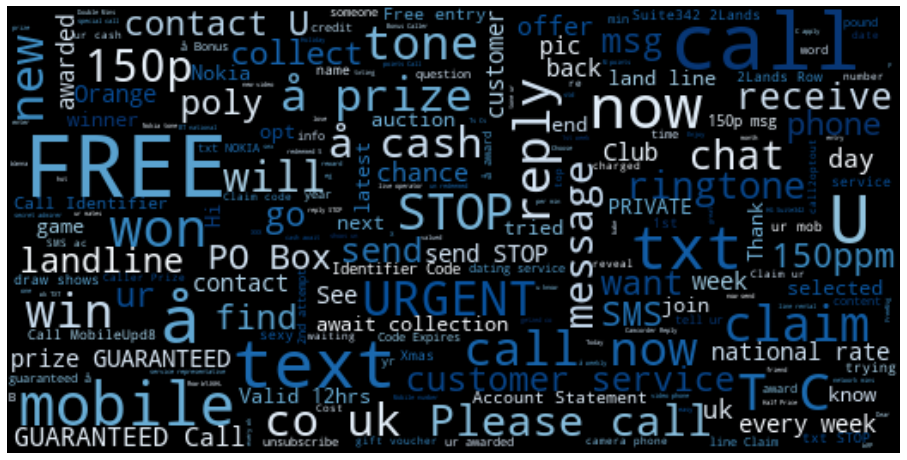

In [33]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

We can also view the distribution in our dataset of ham vs spam:

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

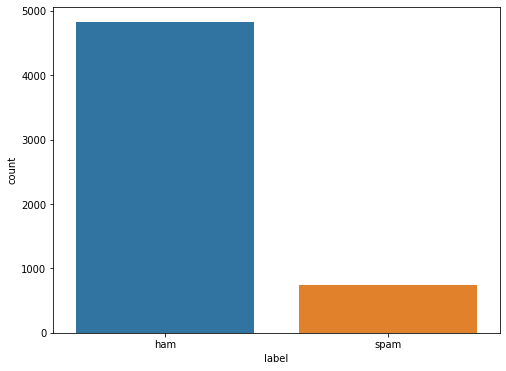

In [34]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

An imbalanced dataset would mean that our model would be substantially less likely to be trained on spam data vs ham data if not accounted for by either resampling the training sets or using different evaluation metrics than a random sample from the dataset.

In [35]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)(747, 2) (747, 2)

(747, 2) (747, 2)


TypeError: 'NoneType' object is not callable

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

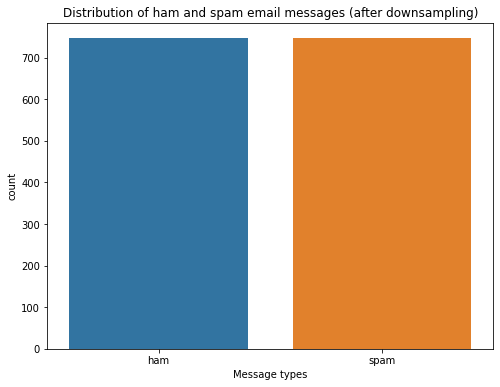

In [36]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

We can see now that our dataset is now balanced. We can additionally view a new wordcloud of our ham and compare that to the above:

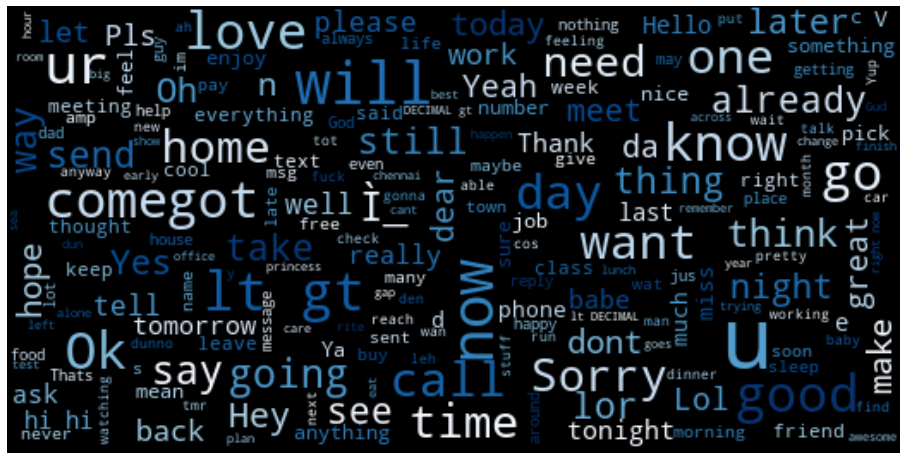

In [37]:
ham_msg_df_text = " ".join(ham_msg_df.message.to_numpy().tolist())
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_df_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()